In [ ]:
# here i will be using a pre-trained model (MobileNetV2) from TensorFlow
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Dataset folders
BASE_DIR = "../dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Hyperparameters
IMAGE_SIZE = (224, 224)   # MobileNetV2 requires 224x224
BATCH_SIZE = 32
EPOCHS = 10


In [3]:
# Use MobileNetV2's preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# Build Transfer Learning Model (MobileNetV2)

# Load base model (pretrained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base layers (to use pretrained features)
base_model.trainable = False

# Add classification head on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Combine
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\DELL\AppData\Local\Temp\ipykernel_9620\3307318988.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Train the Transfer Model

# Callbacks
checkpoint = ModelCheckpoint("../models/mobilenetv2_transfer.keras", save_best_only=True)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 974ms/step - accuracy: 0.9626 - loss: 0.0910 - val_accuracy: 0.9732 - val_loss: 0.0800
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 128s 974ms/step - accuracy: 0.9618 - loss: 0.1000 - val_accuracy: 0.9760 - val_loss: 0.0755
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 128s 977ms/step - accuracy: 0.9740 - loss: 0.0732 - val_accuracy: 0.9741 - val_loss: 0.0782
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 128s 974ms/step - accuracy: 0.9747 - loss: 0.0646 - val_accuracy: 0.9789 - val_loss: 0.0697
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 126s 965ms/step - accuracy: 0.9773 - loss: 0.0571 - val_accuracy: 0.9770 - val_loss: 0.0729
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 969ms/step - accuracy: 0.9722 - loss: 0.0685 - val_accuracy: 0.9616 - val_loss: 0.1073
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 129s 985ms/step - accuracy: 0.9804 - loss: 0.0593 - val_accuracy: 0.9779 - val_loss: 0.0655
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 961ms/step - accuracy: 0.9794 -

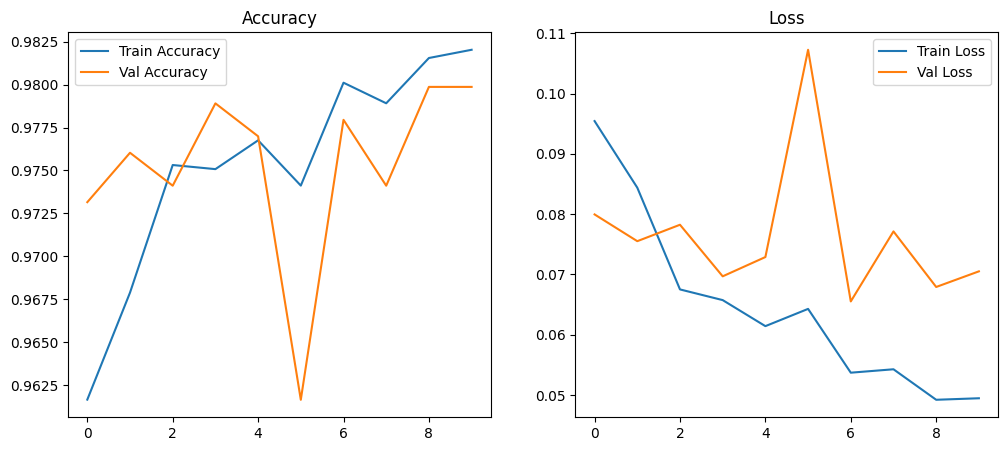

In [7]:
# Plot Accuracy & Loss

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_history(history)



In [ ]:
# Save Final Model

model.save("../models/mobilenetv2_final.keras")


f:\Kaggle\pneumonia-xray-classifier\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 878ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



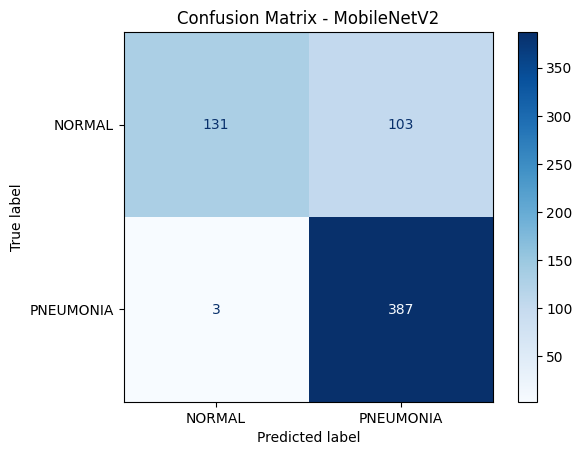

In [ ]:
# Test and Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - MobileNetV2")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

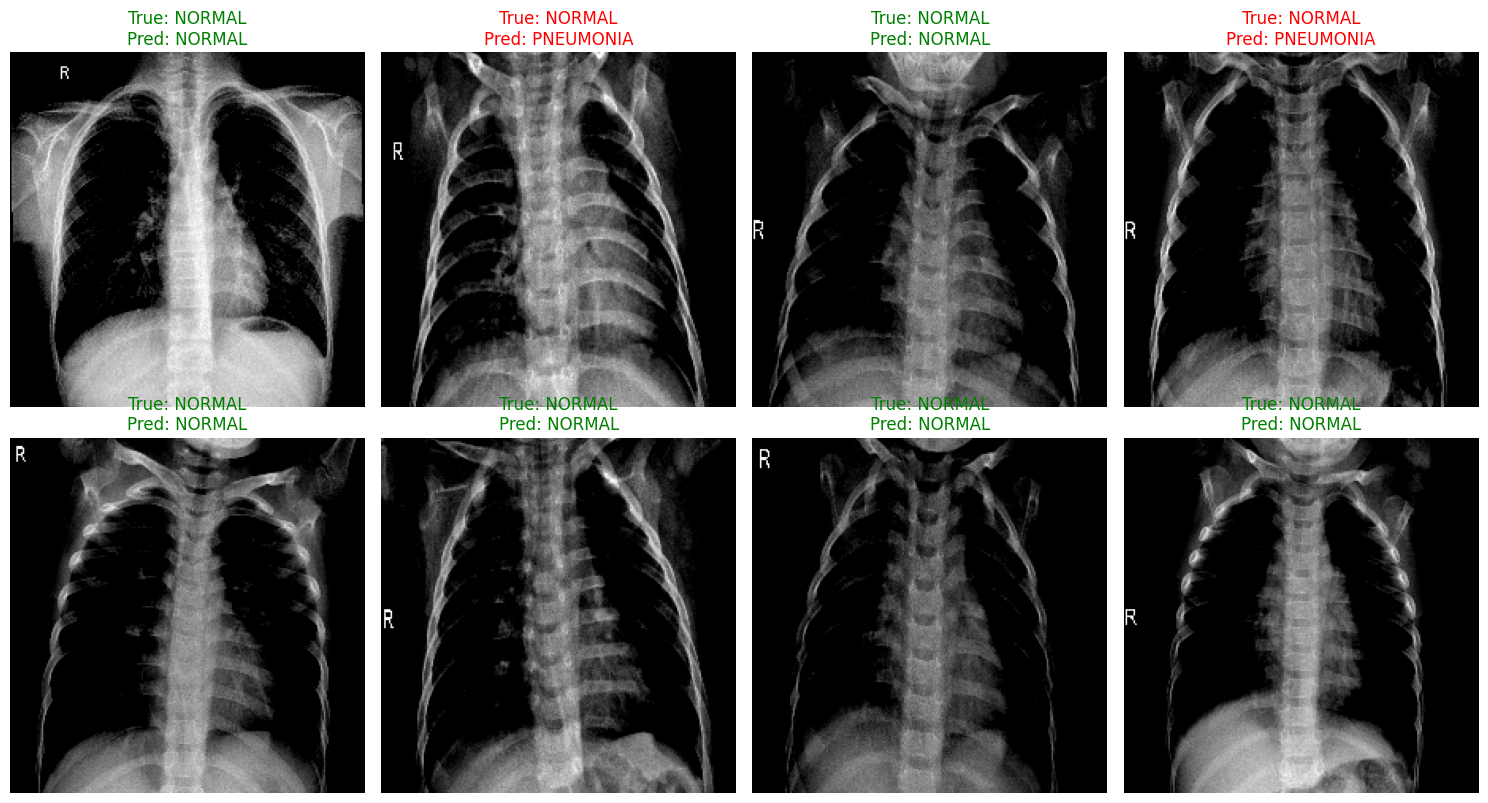

In [16]:
# Visual Prediction Check
import random

# Preview model predictions on a batch of test images
image_batch, label_batch = next(test_generator)
pred_batch = model.predict(image_batch)
pred_labels = (pred_batch > 0.5).astype(int)

# Show 8 examples
plt.figure(figsize=(15, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image_batch[i])
    true_label = list(test_generator.class_indices.keys())[int(label_batch[i])]
    pred_label = list(test_generator.class_indices.keys())[int(pred_labels[i][0])]
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()
